In [1]:
!pip install segyio
!pip install obspy
!pip install PyWavelets

import segyio # to deal with SEG Y Formatted Seismic Data
import numpy as np # for handling arrays
import matplotlib.pyplot as plt # for plotting graphs
import scipy.signal as signal # for signal processing such as filtering, wavelets etc.
import pandas as pd # for data manipulation and analysis
import seaborn as sns # for visualizations

from obspy import read # obspy is being used to handle seismic data, read function opens one or more waveform files
from skimage.restoration import denoise_wavelet # wavelt based technique to reduce noise while preserving important features

# seismic_file = 'f3_seismic.sgy'

  Using cached pywavelets-1.7.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.0 kB)
Using cached pywavelets-1.7.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.5 MB)


In [2]:
import gdown
import segyio

# Data File is uploaded to Google Drive - Here is Google Drive File ID
file_id = '14rMG-ty7i3dTDo7ZkLPWFDFz1ooCgu6e'
output_file = 'f3_seismic.sgy'

# Downloadable url for downloading the Dataset file from Google Drive
download_url = f"https://drive.google.com/uc?id={file_id}"

# Downloading the file from Google Drive
gdown.download(download_url, output_file, quiet=False)

def getSegy3dShape(seismic_file):
    # opening segy file and reading it
    with segyio.open(seismic_file, "r", strict=False) as segyFile:
        # using mmap for memory mapping, mainly for performance based improvements for I/O
        segyFile.mmap()
        # Processing the file to convert to cube and get the seismic data shape
        seismic_cube = segyio.tools.cube(segyFile)
        return seismic_cube.shape

segy_shape_3d = getSegy3dShape(seismic_file)
print(f"Seismic Segy Shape (3d) {segy_shape_3d}")


Downloading...
From (original): https://drive.google.com/uc?id=14rMG-ty7i3dTDo7ZkLPWFDFz1ooCgu6e
From (redirected): https://drive.google.com/uc?id=14rMG-ty7i3dTDo7ZkLPWFDFz1ooCgu6e&confirm=t&uuid=2fe22a59-5f8c-4a80-87e5-c3d10f9f1720
To: /content/f3_seismic.sgy
100%|██████████| 682M/682M [00:10<00:00, 62.2MB/s]


Shape: (601, 901, 255)


In [3]:
def readSegyMultipleInlines2D(seismic_file, start_inline=100, end_inline=200):
    # opening segy file and reading it
    with segyio.open(seismic_file, "r", strict=False) as segyFile:
        # using mmap for memory mapping, mainly for performance based improvements for I/O
        segyFile.mmap()

        # Get Seismic Data Cube
        seismic_cube = segyio.tools.cube(segyFile)
        # Performing Array Slicing and Extracting a Range of Inline Slices
        inlines = seismic_cube[:, start_inline:end_inline, :]
        # Performing row-wise stacking by combing multiple inline slices
        inlines_2d = inlines.reshape(-1, inlines.shape[2])

        return inlines_2d

# Extracting Specific Inline Slices
start_inline = 101
end_inline = 121 # Exclusive

# Loading 2D Data of Multipl Inline Slices
multiple_inline_slices_2D = readSegyMultipleInlines2D(output_file, start_inline, end_inline)
print(f"Seismic Shape (2D Data): {multiple_inline_slices_2D.shape}")

Seismic Shape (2D Data): (12020, 255)


In [4]:
# Extracing Features for Each Inline Trace
def extractInlineSliceTraceFeatures(slice):
    features = {
        "mean": slice.mean(axis=0),
        "std": slice.std(axis=0),
        "max": slice.max(axis=0),
        "min": slice.min(axis=0)
    }
    return pd.DataFrame(features)

# Creating Features DataFrame
inline_slice_trace_features = extractInlineSliceTraceFeatures(multiple_inline_slices_2D)

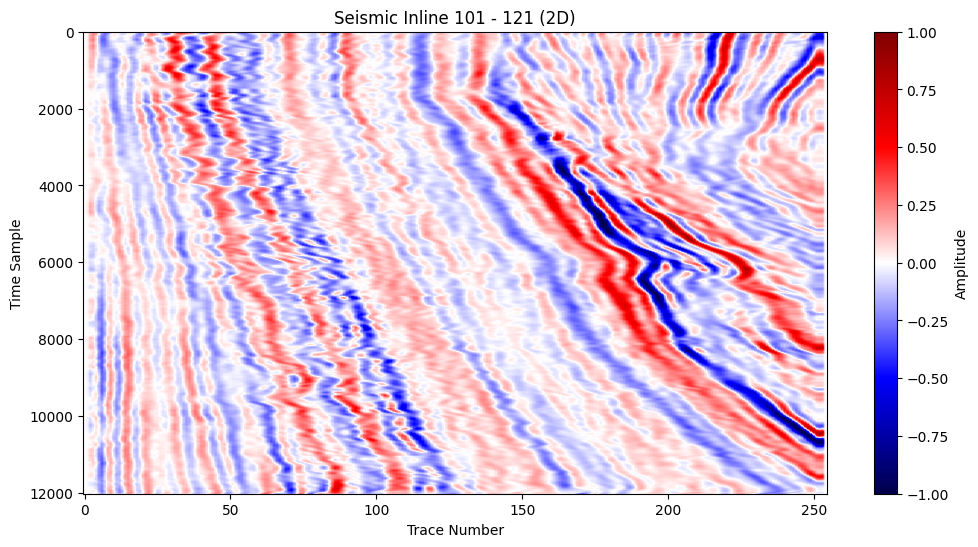

In [5]:
# Plotting Extracted Seismic Section (2D)
def plot2DSection(data, title="Seismic Section (2D)"):
    plt.figure(figsize=(12,6))
    plt.imshow(data, cmap="seismic", aspect="auto") # display data as an image/show an image of dimensions of your matrix
    plt.colorbar(label="Amplitude")
    plt.title(title)
    plt.xlabel('Trace Number')
    plt.ylabel('Time Sample')
    plt.show()

plot2DSection(multiple_inline_slices_2D, title=f"Seismic Inline {start_inline} - {end_inline} (2D)")

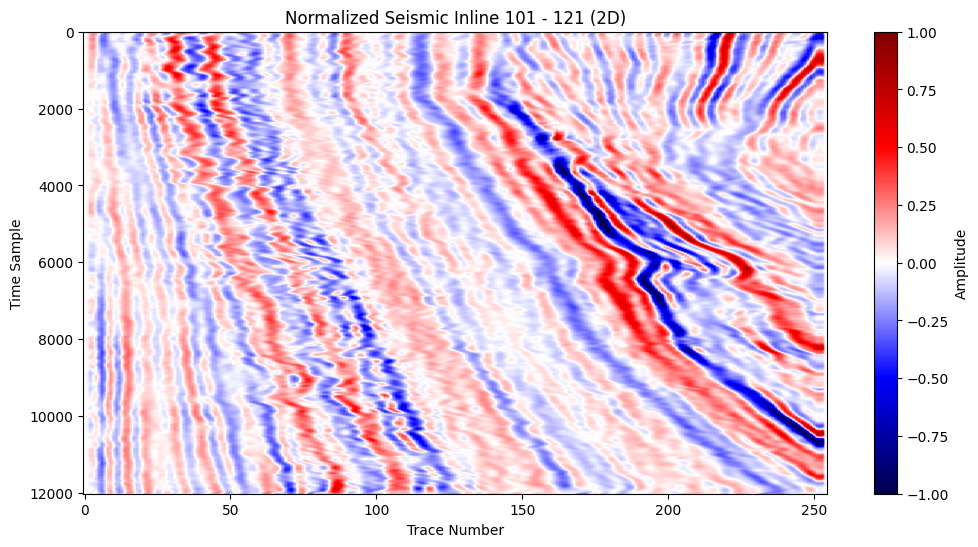

In [6]:
# Normalizing Amplitude
def amplitudeNormalization(inline_slices_data):
    max_val = np.max(np.abs(inline_slices_data)) # get max val from the data
    normalized_data = inline_slices_data/max_val # normalizing the data using maximum value
    return normalized_data

nomralized_inline_slice = amplitudeNormalization(multiple_inline_slices_2D)
plot2DSection(nomralized_inline_slice, title=f'Normalized Seismic Inline {start_inline} - {end_inline} (2D)')

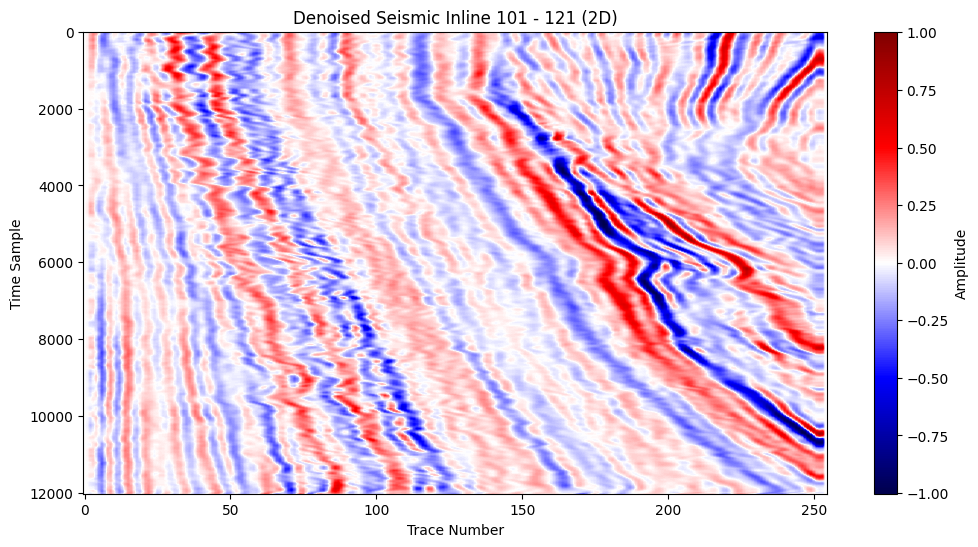

In [7]:
# Reducing Noise Using Wavelet Transform/Shearlet Approximation
def denoiseData(nomralized_inline_slice):
    # redcing noise
    # we shrink the wavelet transform is performed to remove the undesired signal (low amplitude noise)
    # higher the wavelet level, lower the frequency divider b/w frequency and noise
    data_denoised = denoise_wavelet(nomralized_inline_slice, method='BayesShrink', mode='soft', wavelet_levels=3, wavelet='haar', rescale_sigma=True)
    return data_denoised

denoise_inline_slice = denoiseData(nomralized_inline_slice)
plot2DSection(denoise_inline_slice, title=f'Denoised Seismic Inline {start_inline} - {end_inline} (2D)')

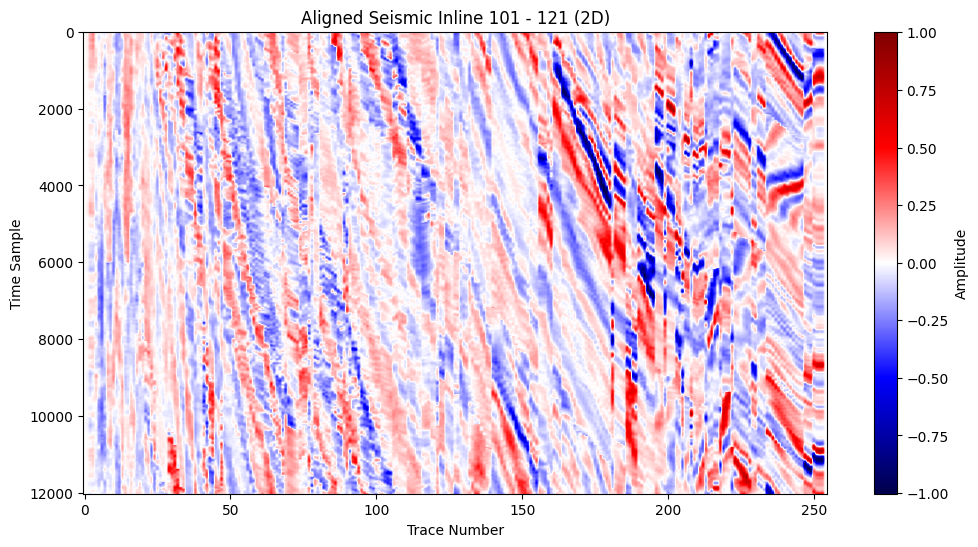

In [8]:
# Traces Alginment Verification (Time Shifts Cross Correlation)
def alignTraces(denoise_inline_slice):
    trace_ref = denoise_inline_slice[:, 0] # chooisng first column as a reference trace, all others will be aligned based on this trace
    data_aligned = np.zeros_like(denoise_inline_slice) # to hold aligned traces, init to zeros
    for i in range(denoise_inline_slice.shape[1]): # loop through all traces
      # computing cross-relation b/w current trace and ref trace
      # cross relation is to measure similarity between the two signal when one gets shifted over the other
      # mode is set to same to ensure that the result get the same length of the trace as input
      # argmax provides us with the index where the cross relation is maximum
      # since the cross relation output is symmetric, we do length // 2 to centered the alignment accuractely
      shift = np.argmax(signal.correlate(denoise_inline_slice[:, i], trace_ref, mode='same')) - len(trace_ref) // 2
      # rolls the current trace via computed shift, +ve shift indicates forward, -ve indicates backward
      data_aligned[:, i] = np.roll(denoise_inline_slice[:, i], shift)
    return data_aligned

aligned_inline_slice = alignTraces(denoise_inline_slice)
plot2DSection(aligned_inline_slice, title=f'Aligned Seismic Inline {start_inline} - {end_inline} (2D)')

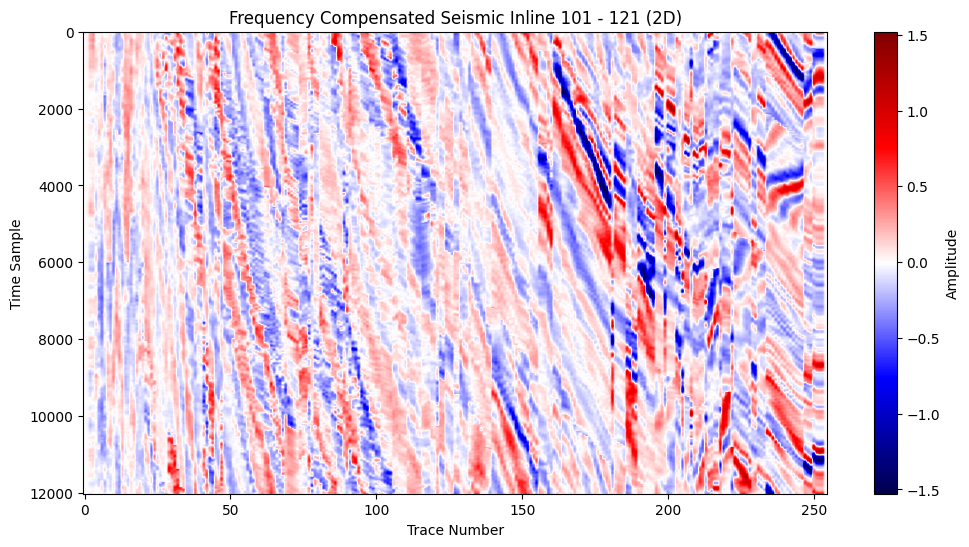

In [9]:
# Applying Frequency Compensation to Aligned Inline Slices
def applyFrequencyCompensation(aligned_inline_slice):
    data_freq = np.fft.fft(aligned_inline_slice, axis=0) # Performing Fourier Transform along time axis converting it from time to frequency domain
    # Applying a compensation filter to boost higher frequencies
    frequency_compensation_filter = np.linspace(1, 2, aligned_inline_slice.shape[0])
    # Modifying Signal Freqeuncy Compnents by Multiplying with Frequency Data
    frequency_compensated_data = data_freq * frequency_compensation_filter[:, np.newaxis]
    # Performing Inverse Fourier Transform to convert it back to time domain and real ensures tor eturn only the real part and discarding the imaginary part
    compensated_data = np.fft.ifft(frequency_compensated_data, axis=0).real
    return compensated_data

frequency_compensated_data = applyFrequencyCompensation(aligned_inline_slice)
plot2DSection(frequency_compensated_data, title=f'Frequency Compensated Seismic Inline {start_inline} - {end_inline} (2D)')

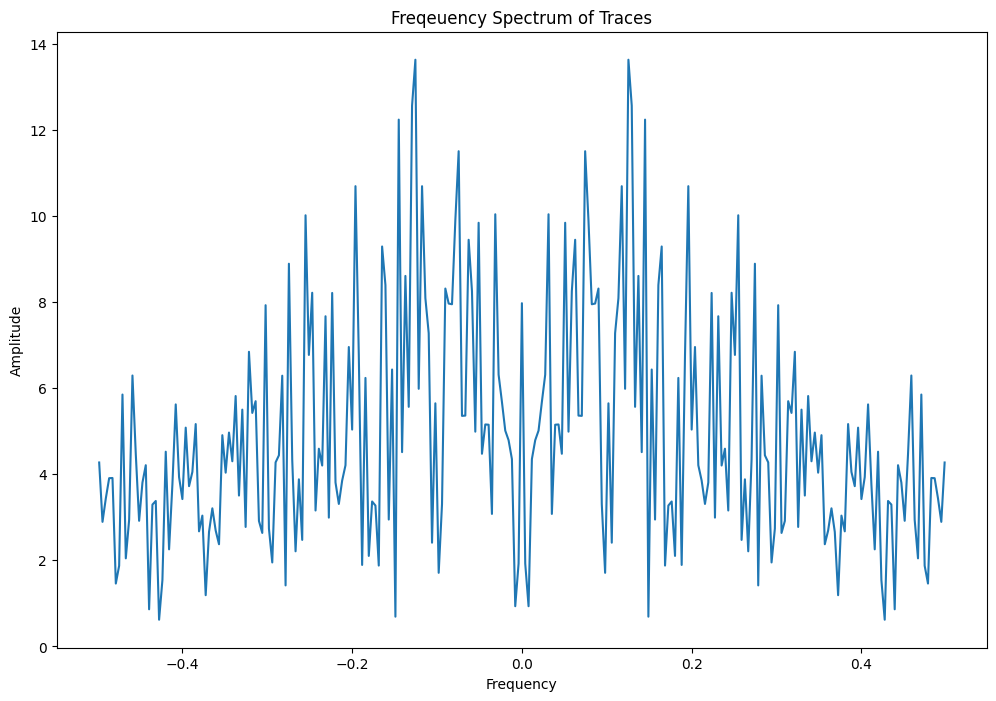

In [10]:
# Frequency/Spectral Analysis
def plotFrequencySpectrum(frequency_compensated_data, title="Frequency Spectrum"):
    # computes foruier transform and shifting zero-spectrum frequency to center for better visuals
    frequency_spectrum = np.fft.fftshift(np.fft.fft(frequency_compensated_data))
    frequency_magnitude = np.abs(frequency_spectrum)
    # computes the corresponding frequency values for spectrum and rearranges it to match the shifted spectrum
    frequencies = np.fft.fftshift(np.fft.fftfreq(len(frequency_compensated_data)))

    plt.figure(figsize=(12,8))
    plt.plot(frequencies, frequency_magnitude)
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.show()

# passing 1D array of 101st entry (index 100) which correspons to single time slice across all traces
plotFrequencySpectrum(frequency_compensated_data[100, :], title="Freqeuency Spectrum of Traces")


In [11]:
# Inpsecting the Shape of Data
print(f"Shape: {frequency_compensated_data.shape}")

# Getting Basic Data
print("Basic Statistics")
print(f"Mean: {np.mean(frequency_compensated_data)}")
print(f"Standard Deviation: {np.std(frequency_compensated_data)}")
print(f"Min: {np.min(frequency_compensated_data)}")
print(f"Max: {np.max(frequency_compensated_data)}")

# Checking Missing Values
has_NAN = np.isnan(frequency_compensated_data).any()
print(f"Missing Values: {has_NAN}")

Shape: (12020, 255)
Basic Statistics
Mean: 0.0027839406114767147
Standard Deviation: 0.33004947604645474
Min: -1.5280852711651391
Max: 1.520065449778614
Missing Values: False


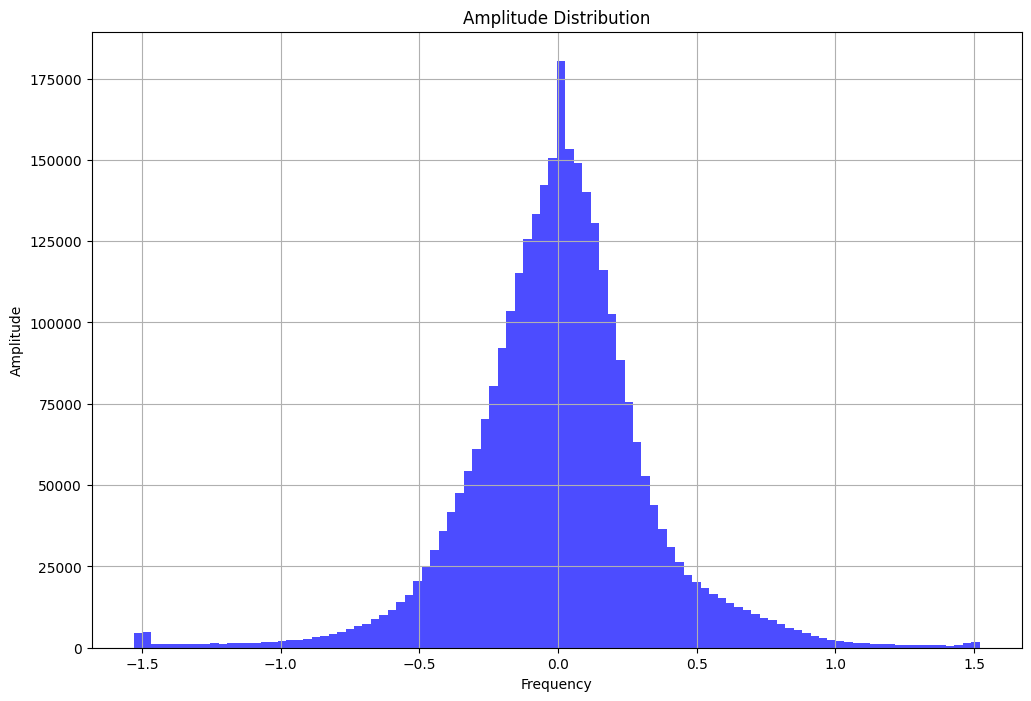

In [12]:
# Amplitude Histogram
plt.figure(figsize=(12,8))
plt.hist(frequency_compensated_data.flatten(), bins=100, color='blue', alpha=0.7)
plt.title("Amplitude Distribution")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

In [13]:
# Exytracting Features (Phase & Amplitude)
def extractFeatures(frequency_compensated_data):
    amplitude = np.abs(frequency_compensated_data)
    phase = np.angle(np.fft.fft(frequency_compensated_data, axis=0)) # extracts phase of numbers getting from Fourier Transform
    return phase, amplitude

phase, amplitude = extractFeatures(frequency_compensated_data)

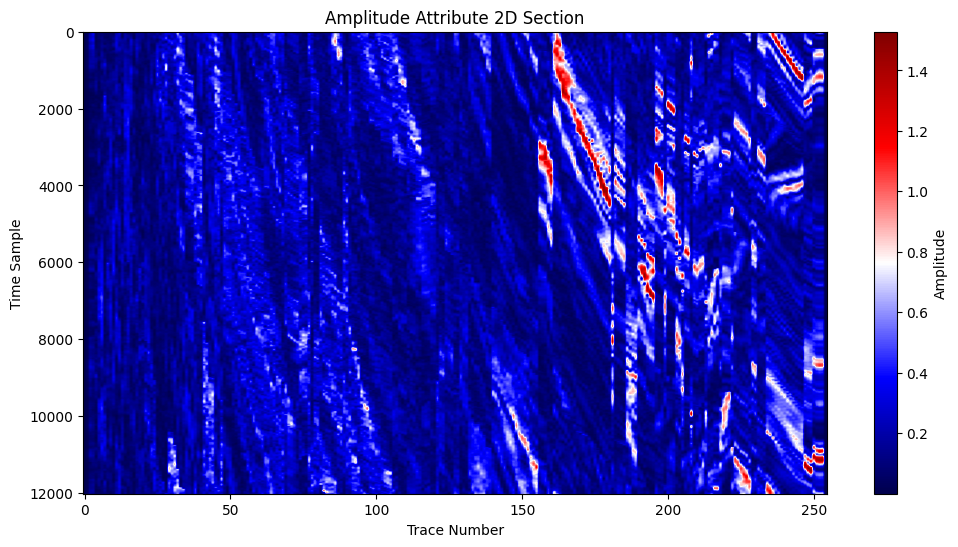

In [14]:
plot2DSection(amplitude, title="Amplitude Attribute 2D Section")

In [15]:
def detectFrequencyAnomalies(frequency_compensated_data):
    '''
      Using threshold factor to detect anomalies
      Using Frequency Compensated Seismic Data (2D Numpy Array)
      threshold factor: multiplier for the SD to set the anomaly threshold
      returns boolean mask of detected anomalies
    '''
    # computing mean and stnadard deviation
    std_dev = np.std(frequency_compensated_data)
    mean_val = np.mean(frequency_compensated_data)

    # setting up threshold
    lower_threshold = mean_val - 1 * std_dev # upto 1 S.D left from mean
    upper_threshold = mean_val + 2 * std_dev # upto 2 S.D right from mean

    print(mean_val)
    print(std_dev)
    print(upper_threshold)
    print(lower_threshold)

    # creating mask for anomalies where data exceeds the threshold
    masked_anomaly = (frequency_compensated_data > upper_threshold) | (frequency_compensated_data < lower_threshold)

    return masked_anomaly

# Find anomalies in frequency compensated data
anomalies = detectFrequencyAnomalies(frequency_compensated_data)

0.0027839406114767147
0.33004947604645474
0.6628828927043862
-0.32726553543497805


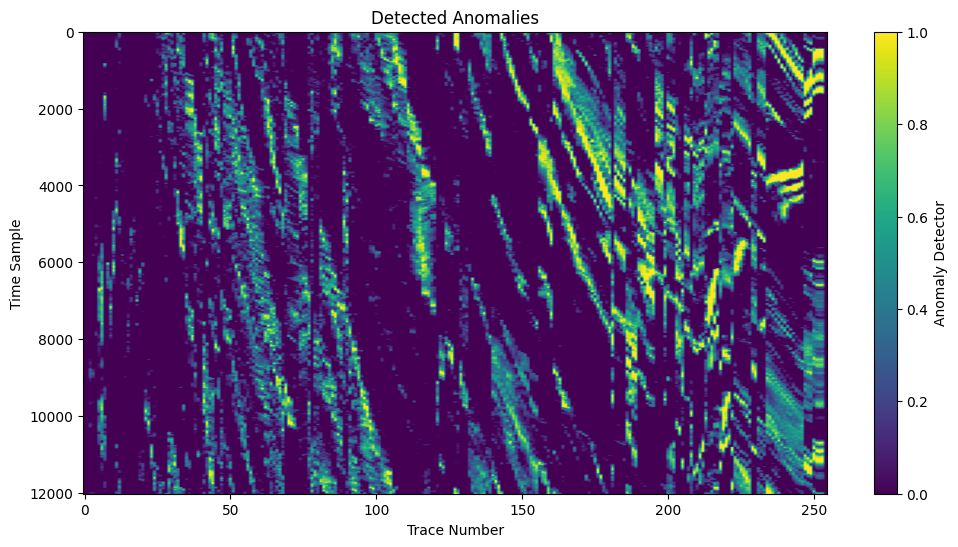

Anomaly Detection Completed.


In [16]:
# Plot Detected Anomalies
plt.figure(figsize=(12,6))
plt.imshow(anomalies, cmap='viridis', aspect='auto')
plt.colorbar(label="Anomaly Detector")
plt.title("Detected Anomalies")
plt.xlabel("Trace Number")
plt.ylabel("Time Sample")
plt.show()

print("Anomaly Detection Completed.")

In [18]:
# Separate Non-Anomalous and Anomalous Points
anomalous_values = frequency_compensated_data[anomalies]
normal_values = frequency_compensated_data[~anomalies]

print(f"Normal Data Statistics: Mean: {np.mean(normal_values)}, Std Dev: {np.std(normal_values)}")
print(f"Anomalous Data Statistics: Mean: {np.mean(anomalous_values)}, Std Dev: {np.std(anomalous_values)}")

Normal Data Statistics: Mean: 0.04874577260722781, Std Dev: 0.20629169960622593
Anomalous Data Statistics: Mean: -0.2644520007566744, Std Dev: 0.6412232807679867


In [20]:
anomalous_values.shape

(449804,)

In [21]:
normal_values.shape

(2615296,)

In [22]:
# Counting anomalies along time samples and traces
time_sample_anomalies = np.sum(anomalies, axis=1)
print(time_sample_anomalies)
trace_anomalies = np.sum(anomalies, axis=0)
print(trace_anomalies)

[34 34 39 ... 41 34 29]
[   0    0  119   54   54 1163 2601  885  259  457  854  680  417   42
   14  190  231   65  114  205  142  414  435  415  451  317  300  486
  952  969  863 1091 1373 1478 1420 1371 1625 1915 1654 1428 1561 1756
 2029 2151 2486 2384 2006 1544 1598 1862 1998 2248 2070 2181 2251 2114
 2146 2124 2398 2286 2046 2259 2396 2728 2579 2369 2093 2122 1887 1781
 1574 1545 1563 1565 1813 1956 1934 1710 1542 1420 1451 1763 1825 1755
 1978 2497 2743 2151 1837 1912 1680 1598 1589 1453 1259 1463 1764 1950
 1836 1508 1304 1302 1251 1250 1324 1403 1356 1208 1308 1190 1018  932
 1213 1735 2161 2425 2374 2131 1713 1164  865  779  737  694  657  685
  697  760  909  871  753  719  745  963 1022  970 1100 1334 1384 1257
 1262 1295 1255 1226 1510 1840 1916 1635 1560 1674 1643 1460 1201 1047
 1205 1375 1478 1704 1900 2091 2289 2194 2292 2189 2243 2102 2172 2150
 2103 1971 1724 1650 1668 1600 1864 2093 2252 2248 2250 2554 2857 2668
 2332 2427 2441 2482 2688 3196 3062 2713 2324 2275 24

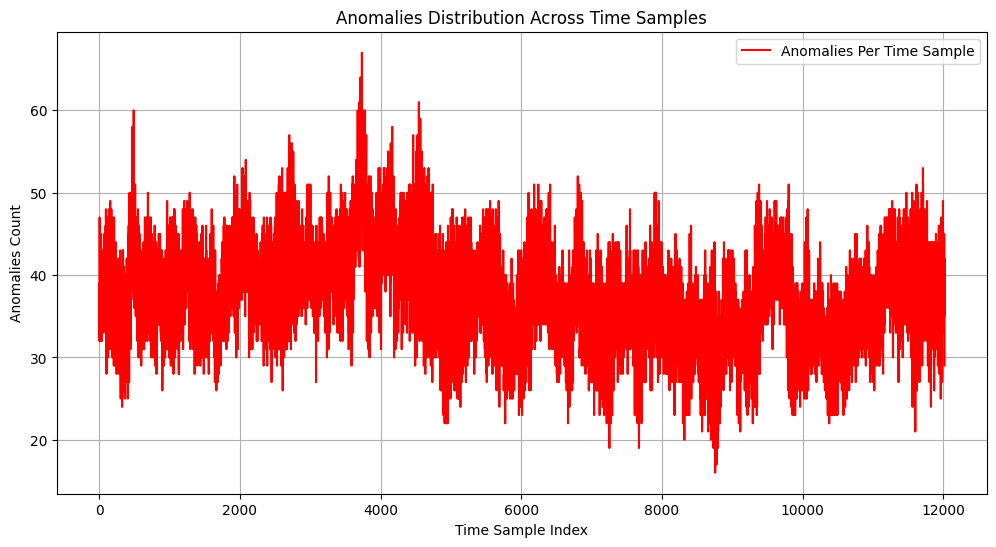

In [23]:
# Plot Time Sample Anomalies
plt.figure(figsize=(12,6))
plt.plot(time_sample_anomalies, label="Anomalies Per Time Sample", color="red")
plt.title("Anomalies Distribution Across Time Samples")
plt.xlabel("Time Sample Index")
plt.ylabel("Anomalies Count")
plt.legend()
plt.grid()
plt.show()

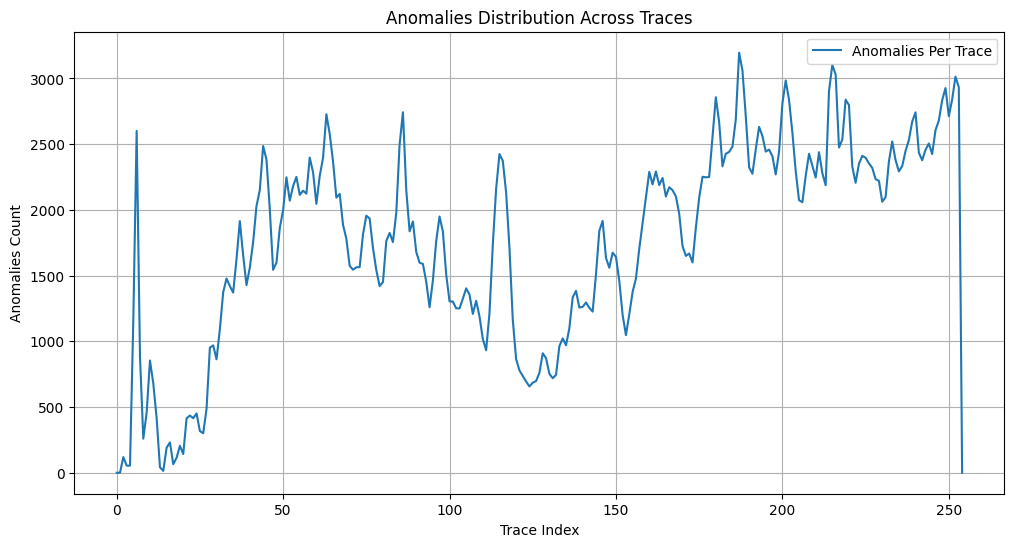

In [24]:
# Plot Trace Anomalies
plt.figure(figsize=(12,6))
plt.plot(trace_anomalies, label="Anomalies Per Trace")
plt.title("Anomalies Distribution Across Traces")
plt.xlabel("Trace Index")
plt.ylabel("Anomalies Count")
plt.legend()
plt.grid()
plt.show()

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE # adding synthetic data to balance an imbalance dataset

# labels for classification, 1 for anomaly, 0 for normal or not anomaly
labels = anomalies.astype(int)

X = np.argwhere(frequency_compensated_data) # All data points indices
Y = labels.flatten() # 1 for anomaly, 0 for normal

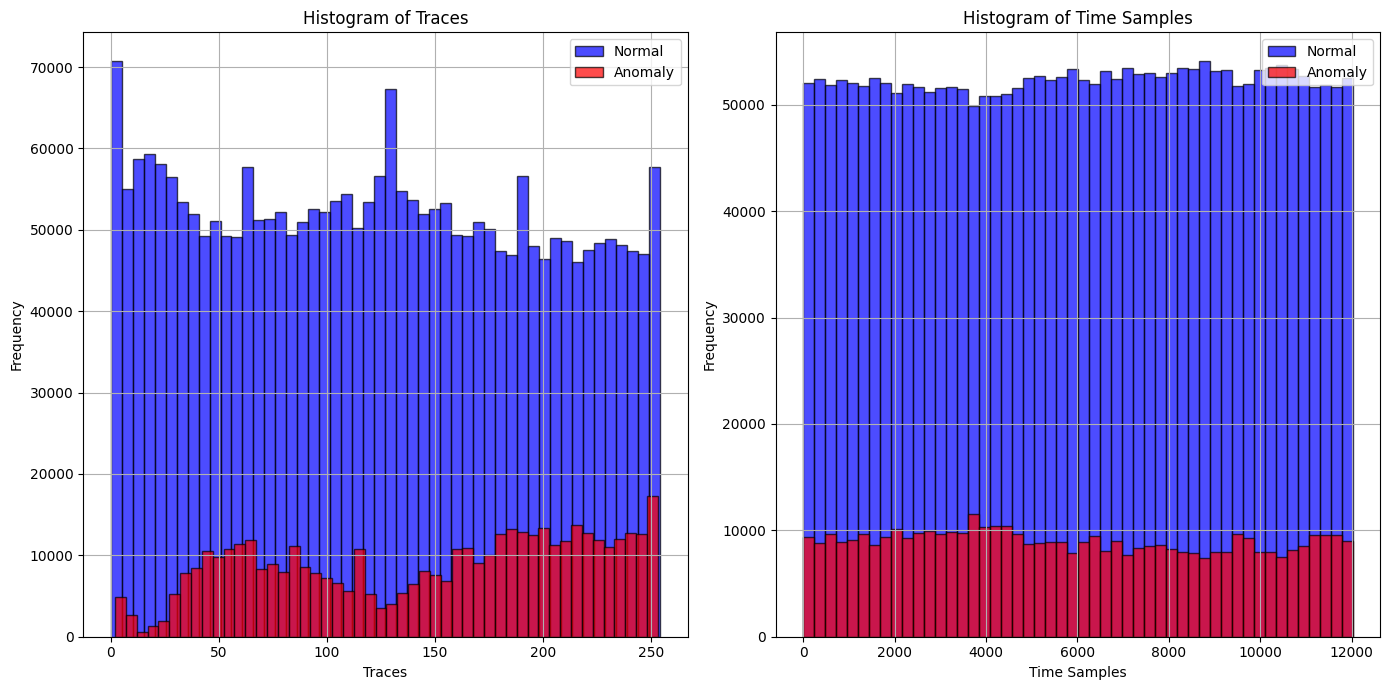

In [41]:
X_anomalous_points = X[Y == 1]
X_normal_points = X[Y == 0]

# Generating Histogram for Anomalous and Normal Points
plt.figure(figsize=(14, 7))

# Plotting Original Data Distribution
# Plotting the histogram for normal points and anomalous - Traces
plt.subplot(1, 2, 1)
plt.hist(X_normal_points[:, 1], bins=50, alpha=0.7, label="Normal", color="blue", edgecolor="black")
plt.hist(X_anomalous_points[:, 1], bins=50, alpha=0.7, label="Anomaly", color="red", edgecolor="black")
plt.title("Histogram of Traces")
plt.xlabel("Traces")
plt.ylabel("Frequency")
plt.legend()
plt.grid()

# Plotting the histogram for normal points and anomalous - Time Samples
plt.subplot(1, 2, 2)
plt.hist(X_normal_points[:, 0], bins=50, alpha=0.7, label="Normal", color="blue", edgecolor="black")
plt.hist(X_anomalous_points[:, 0], bins=50, alpha=0.7, label="Anomaly", color="red", edgecolor="black")
plt.title("Histogram of Time Samples")
plt.xlabel("Time Samples")
plt.ylabel("Frequency")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [43]:
X_anomalous_points.shape

(449804, 2)

In [44]:
X_normal_points.shape

(2615296, 2)

In [49]:
# Data Proportion / Distribution Before Applying SMOTE
total_points_count = (X_anomalous_points.size + X_normal_points.size)/2
print(f"Total Points Count: {total_points_count}")
anomalous_points_count = (X_anomalous_points.size)/2
print(f"Anomalous Points Count: {(anomalous_points_count)}")
print(f"Normal Points Count: {(total_points_count - anomalous_points_count)}")
anomalous_percentage = (anomalous_points_count / total_points_count) * 100
print(f"Anomalous Points: {anomalous_percentage:.2f} %")
print(f"Normal Points: {100 - anomalous_percentage:.2f} %")

Total Points Count: 3065100.0
Anomalous Points Count: 449804.0
Normal Points Count: 2615296.0
Anomalous Points: 14.68 %
Normal Points: 85.32 %


In [37]:
# Balancing Dataset Via SMOTE
smote = SMOTE(random_state=42)
X_balanced, Y_balanced = smote.fit_resample(X, Y)

In [38]:
X_balanced.shape

(5230592, 2)

In [39]:
Y_balanced.shape

(5230592,)

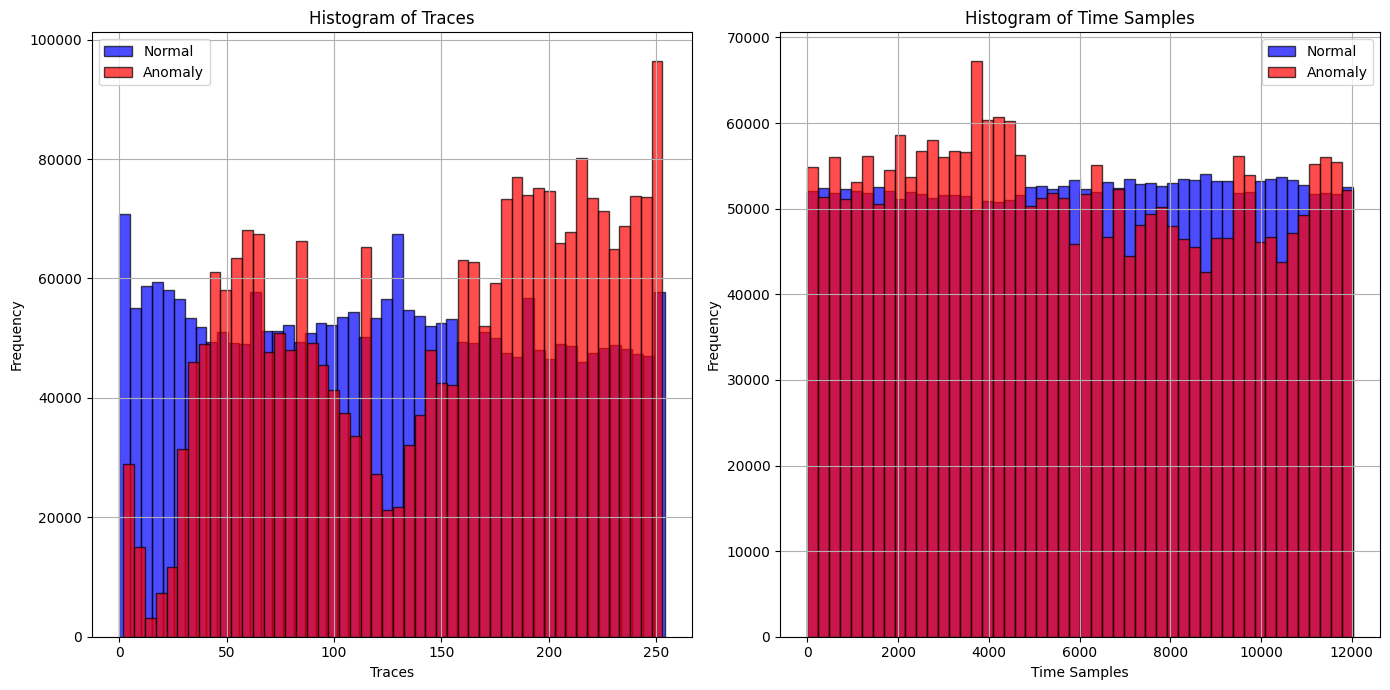

In [40]:
X_balanced_anomalous = X_balanced[Y_balanced == 1]
X_balanced_normal = X_balanced[Y_balanced == 0]

# Generating Histogram for Anomalous and Normal Points
plt.figure(figsize=(14, 7))

# Plotting Balanced Data Distribution
# Plotting the histogram for normal points and anomalous - Traces
plt.subplot(1, 2, 1)
plt.hist(X_balanced_normal[:, 1], bins=50, alpha=0.7, label="Normal", color="blue", edgecolor="black")
plt.hist(X_balanced_anomalous[:, 1], bins=50, alpha=0.7, label="Anomaly", color="red", edgecolor="black")
plt.title("Histogram of Traces")
plt.xlabel("Traces")
plt.ylabel("Frequency")
plt.legend()
plt.grid()

# Plotting the histogram for normal points and anomalous - Time Samples
plt.subplot(1, 2, 2)
plt.hist(X_balanced_normal[:, 0], bins=50, alpha=0.7, label="Normal", color="blue", edgecolor="black")
plt.hist(X_balanced_anomalous[:, 0], bins=50, alpha=0.7, label="Anomaly", color="red", edgecolor="black")
plt.title("Histogram of Time Samples")
plt.xlabel("Time Samples")
plt.ylabel("Frequency")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [46]:
X_balanced_anomalous.shape

(2615296, 2)

In [47]:
X_balanced_normal.shape

(2615296, 2)

In [51]:
# Data Proportion / Distribution After Applying SMOTE
total_points_count = (X_balanced_anomalous.size + X_balanced_normal.size)/2
print(f"Total Points Count: {total_points_count}")
anomalous_points_count = (X_balanced_anomalous.size)/2
print(f"Anomalous Points Count: {(anomalous_points_count)}")
print(f"Normal Points Count: {(total_points_count - anomalous_points_count)}")
anomalous_percentage = (anomalous_points_count / total_points_count) * 100
print(f"Anomalous Points: {anomalous_percentage:.2f} %")
print(f"Normal Points: {100 - anomalous_percentage:.2f} %")

Total Points Count: 5230592.0
Anomalous Points Count: 2615296.0
Normal Points Count: 2615296.0
Anomalous Points: 50.00 %
Normal Points: 50.00 %


In [52]:
# Splitting Dataset into Training and Testing (80/20)
X_train, X_test, Y_train, Y_test = train_test_split(X_balanced, Y_balanced, test_size=0.2, random_state=42)

In [53]:
X_train.shape

(4184473, 2)

In [54]:
X_test.shape

(1046119, 2)

In [55]:
Y_train.shape

(4184473,)

In [56]:
Y_test.shape

(1046119,)

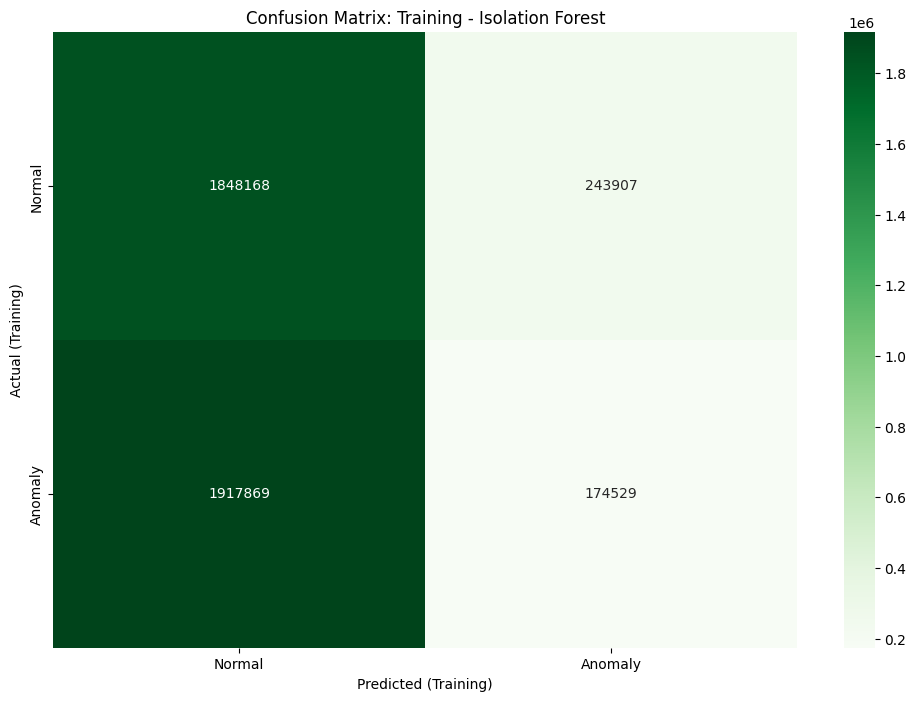

Training Data Performance Metrics - Isolation Forest
Accuracy: 0.48
Precision: 0.42
Recall: 0.08
F1: 0.14
Specificity: 0.88


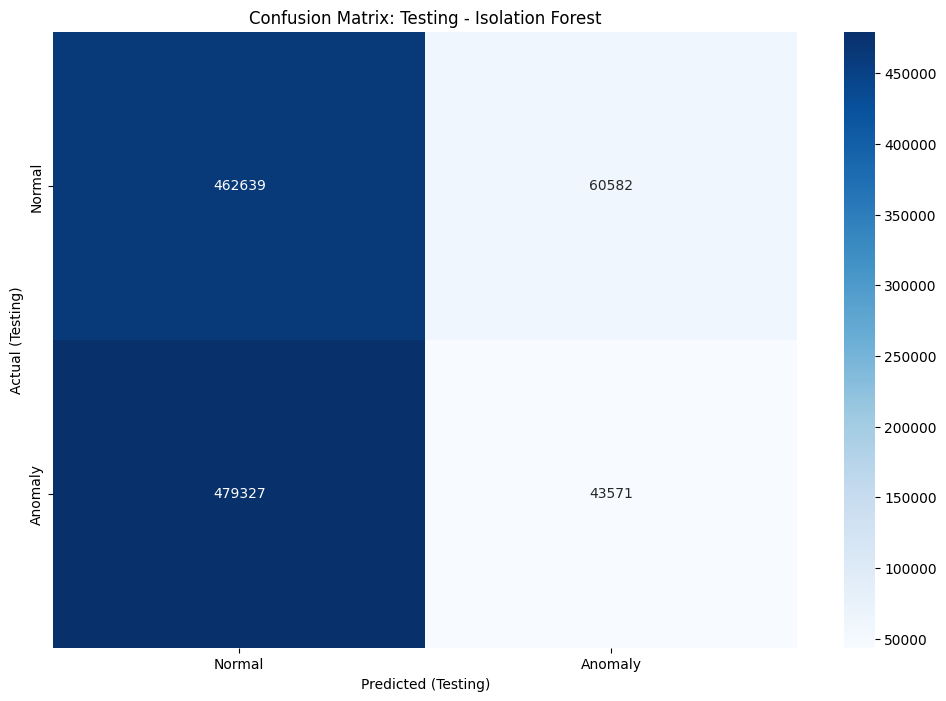

Testing Data Performance Metrics - Isolation Forest
Accuracy: 0.48
Precision: 0.42
Recall: 0.08
F1: 0.14
Specificity: 0.88


In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix

# Initialize Isolation Forest model
isolation_model = IsolationForest(contamination=0.1, random_state=42)  # Adjust contamination based on anomaly ratio
isolation_model.fit(X_train)

# Predict anomaly scores and labels for Training and Testing
Y_train_prediction_binary = isolation_model.predict(X_train)
Y_test_prediction_binary = isolation_model.predict(X_test)

# Convert IsolationForest predictions to binary (1 = anomaly, 0 = normal)
Y_train_prediction_binary = (Y_train_prediction_binary == -1).astype(int)  # -1 is anomaly, 1 is normal
Y_test_prediction_binary = (Y_test_prediction_binary == -1).astype(int)

# Calculate Confusion Matrices
training_confusion_matrix = confusion_matrix(Y_train, Y_train_prediction_binary)
testing_confusion_matrix = confusion_matrix(Y_test, Y_test_prediction_binary)

# Confusion Matrix Visual (Training)
plt.figure(figsize=(12,8))
sns.heatmap(training_confusion_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix: Training - Isolation Forest")
plt.xlabel("Predicted (Training)")
plt.ylabel("Actual (Training)")
plt.show()

# Training Data Performance Metrics
print("Training Data Performance Metrics - Isolation Forest")
training_accuracy = accuracy_score(Y_train, Y_train_prediction_binary)
print(f"Accuracy: {training_accuracy:.2f}")
training_precision = precision_score(Y_train, Y_train_prediction_binary, zero_division=0)
print(f"Precision: {training_precision:.2f}")
training_recall = recall_score(Y_train, Y_train_prediction_binary, zero_division=0)
print(f"Recall: {training_recall:.2f}")
training_f1 = f1_score(Y_train, Y_train_prediction_binary)
print(f"F1: {training_f1:.2f}")
specificity_train =  training_confusion_matrix[0, 0] / (training_confusion_matrix[0, 0] + training_confusion_matrix[0, 1]) if (training_confusion_matrix[0, 0] + training_confusion_matrix[0, 1]) > 0 else 0
print(f"Specificity: {specificity_train:.2f}")

# Confusion Matrix Visual (Testing)
plt.figure(figsize=(12,8))
sns.heatmap(testing_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix: Testing - Isolation Forest")
plt.xlabel("Predicted (Testing)")
plt.ylabel("Actual (Testing)")
plt.show()

# Testing Data Performance Metrics
print("Testing Data Performance Metrics - Isolation Forest")
testing_accuracy = accuracy_score(Y_test, Y_test_prediction_binary)
print(f"Accuracy: {testing_accuracy:.2f}")
testing_precision = precision_score(Y_test, Y_test_prediction_binary, zero_division=0)
print(f"Precision: {testing_precision:.2f}")
testing_recall = recall_score(Y_test, Y_test_prediction_binary, zero_division=0)
print(f"Recall: {testing_recall:.2f}")
testing_f1 = f1_score(Y_test, Y_test_prediction_binary)
print(f"F1: {testing_f1:.2f}")
specificity_test =  testing_confusion_matrix[0, 0] / (testing_confusion_matrix[0, 0] + testing_confusion_matrix[0, 1]) if (testing_confusion_matrix[0, 0] + testing_confusion_matrix[0, 1]) > 0 else 0
print(f"Specificity: {specificity_test:.2f}")



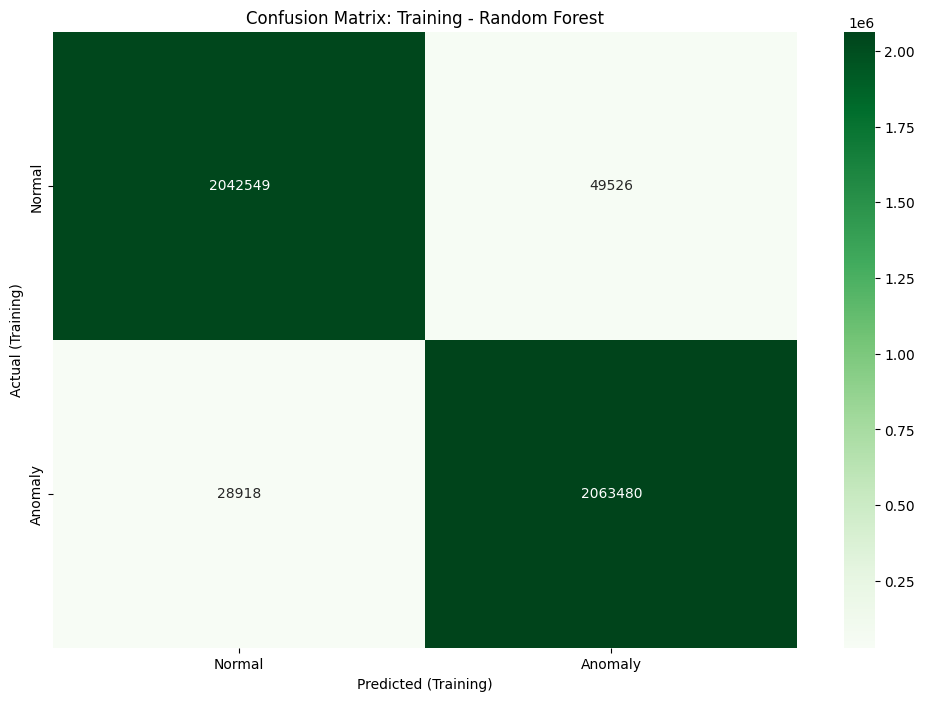

Training Data Performance Metrics - Random Forest
Accuracy: 0.98
Precision: 0.98
Recall: 0.99
F1: 0.98
Specificity: 0.98


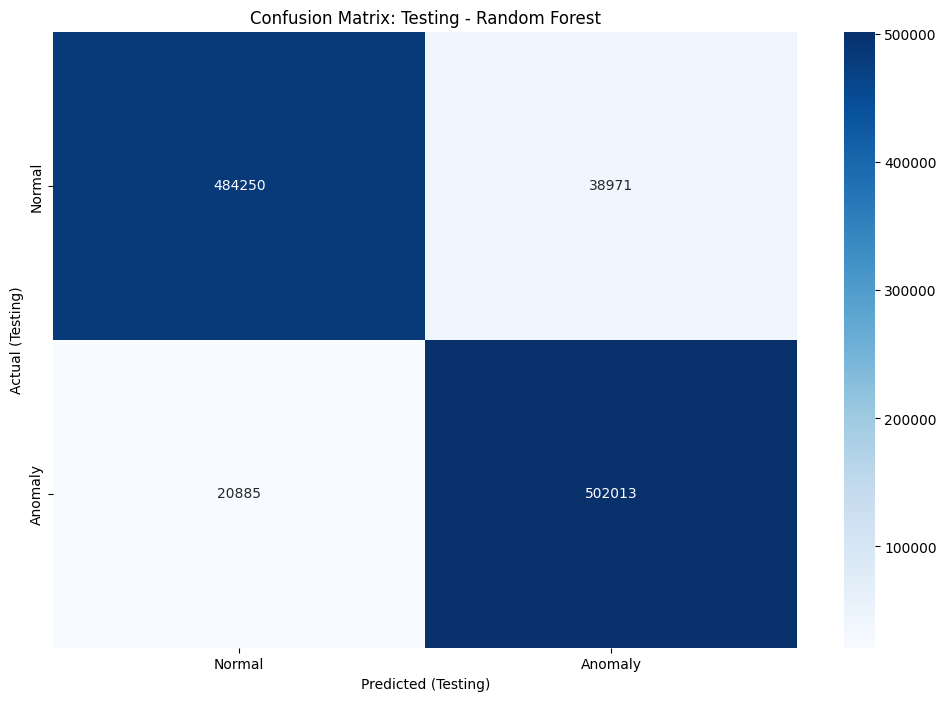

Testing Data Performance Metrics - Random Forest
Accuracy: 0.94
Precision: 0.93
Recall: 0.96
F1: 0.94
Specificity: 0.93


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, Y_train)

# Predict labels for Training and Testing sets
Y_train_prediction_binary = rf_model.predict(X_train)
Y_test_prediction_binary = rf_model.predict(X_test)

# Calculate Confusion Matrices
training_confusion_matrix = confusion_matrix(Y_train, Y_train_prediction_binary)
testing_confusion_matrix = confusion_matrix(Y_test, Y_test_prediction_binary)

# Confusion Matrix Visual (Training)
plt.figure(figsize=(12,8))
sns.heatmap(training_confusion_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix: Training - Random Forest")
plt.xlabel("Predicted (Training)")
plt.ylabel("Actual (Training)")
plt.show()

# Training Data Performance Metrics
print("Training Data Performance Metrics - Random Forest")
training_accuracy = accuracy_score(Y_train, Y_train_prediction_binary)
print(f"Accuracy: {training_accuracy:.2f}")
training_precision = precision_score(Y_train, Y_train_prediction_binary, zero_division=0)
print(f"Precision: {training_precision:.2f}")
training_recall = recall_score(Y_train, Y_train_prediction_binary, zero_division=0)
print(f"Recall: {training_recall:.2f}")
training_f1 = f1_score(Y_train, Y_train_prediction_binary)
print(f"F1: {training_f1:.2f}")
specificity_train =  training_confusion_matrix[0, 0] / (training_confusion_matrix[0, 0] + training_confusion_matrix[0, 1]) if (training_confusion_matrix[0, 0] + training_confusion_matrix[0, 1]) > 0 else 0
print(f"Specificity: {specificity_train:.2f}")

# Confusion Matrix Visual (Testing)
plt.figure(figsize=(12,8))
sns.heatmap(testing_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix: Testing - Random Forest")
plt.xlabel("Predicted (Testing)")
plt.ylabel("Actual (Testing)")
plt.show()

# Testing Data Performance Metrics
print("Testing Data Performance Metrics - Random Forest")
testing_accuracy = accuracy_score(Y_test, Y_test_prediction_binary)
print(f"Accuracy: {testing_accuracy:.2f}")
testing_precision = precision_score(Y_test, Y_test_prediction_binary, zero_division=0)
print(f"Precision: {testing_precision:.2f}")
testing_recall = recall_score(Y_test, Y_test_prediction_binary, zero_division=0)
print(f"Recall: {testing_recall:.2f}")
testing_f1 = f1_score(Y_test, Y_test_prediction_binary)
print(f"F1: {testing_f1:.2f}")
specificity_test =  testing_confusion_matrix[0, 0] / (testing_confusion_matrix[0, 0] + testing_confusion_matrix[0, 1]) if (testing_confusion_matrix[0, 0] + testing_confusion_matrix[0, 1]) > 0 else 0
print(f"Specificity: {specificity_test:.2f}")



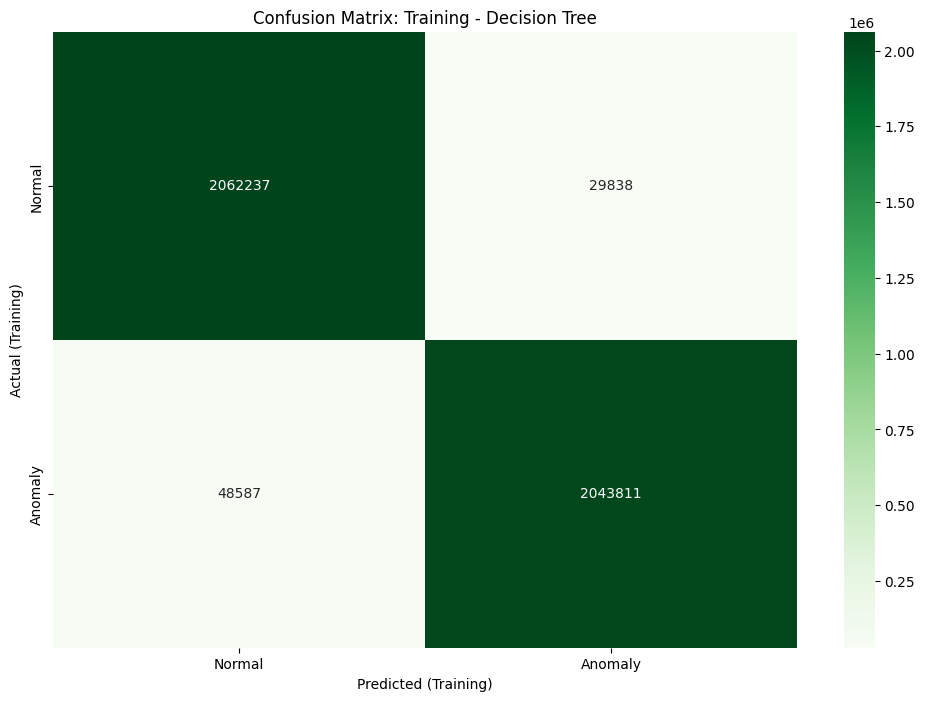

Training Data Performance Metrics - Decision Tree
Accuracy: 0.98
Precision: 0.99
Recall: 0.98
F1: 0.98
Specificity: 0.99


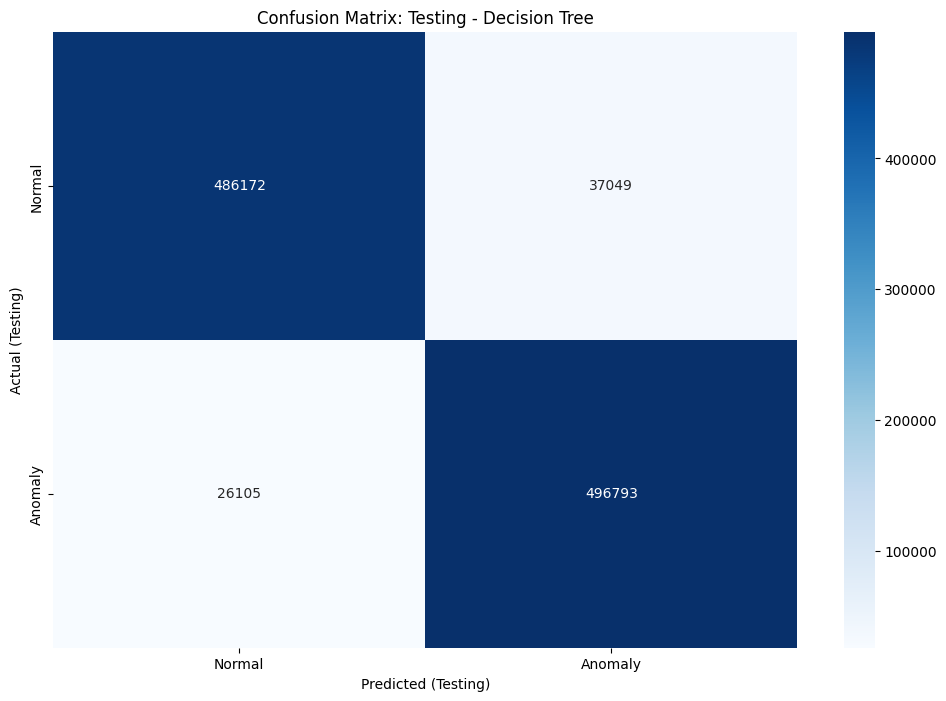

Testing Data Performance Metrics - Decision Tree
Accuracy: 0.94
Precision: 0.93
Recall: 0.95
F1: 0.94
Specificity: 0.93


In [ ]:
from sklearn.tree import DecisionTreeClassifier # Classify instances based on their feature values

# Decision Tree Classifier Training
model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, Y_train)

# Predict anomalies on training an testing data
Y_train_prediction_binary = model.predict(X_train)
Y_test_prediction_binary = model.predict(X_test)

# Calculate Confusion Matrix for Training and Testing
training_confusion_matrix = confusion_matrix(Y_train, Y_train_prediction_binary)
testing_confusion_matrix = confusion_matrix(Y_test, Y_test_prediction_binary)

# Confusion Matrix Visual (Training)
plt.figure(figsize=(12,8))
sns.heatmap(training_confusion_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix: Training - Decision Tree")
plt.xlabel("Predicted (Training)")
plt.ylabel("Actual (Training)")
plt.show()

# Training Data Performance Metrics
print("Training Data Performance Metrics - Decision Tree")
training_accuracy = accuracy_score(Y_train, Y_train_prediction_binary)
print(f"Accuracy: {training_accuracy:.2f}")
training_precision = precision_score(Y_train, Y_train_prediction_binary, zero_division=0)
print(f"Precision: {training_precision:.2f}")
training_recall = recall_score(Y_train, Y_train_prediction_binary, zero_division=0)
print(f"Recall: {training_recall:.2f}")
training_f1 = f1_score(Y_train, Y_train_prediction_binary)
print(f"F1: {training_f1:.2f}")
specificity_train =  training_confusion_matrix[0, 0] / (training_confusion_matrix[0, 0] + training_confusion_matrix[0, 1]) if (training_confusion_matrix[0, 0] + training_confusion_matrix[0, 1]) > 0 else 0
print(f"Specificity: {specificity_train:.2f}")

# Confusion Matrix Visual (Testing)
plt.figure(figsize=(12,8))
sns.heatmap(testing_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix: Testing - Decision Tree")
plt.xlabel("Predicted (Testing)")
plt.ylabel("Actual (Testing)")
plt.show()

# Testing Data Performance Metrics
print("Testing Data Performance Metrics - Decision Tree")
testing_accuracy = accuracy_score(Y_test, Y_test_prediction_binary)
print(f"Accuracy: {testing_accuracy:.2f}")
testing_precision = precision_score(Y_test, Y_test_prediction_binary, zero_division=0)
print(f"Precision: {testing_precision:.2f}")
testing_recall = recall_score(Y_test, Y_test_prediction_binary, zero_division=0)
print(f"Recall: {testing_recall:.2f}")
testing_f1 = f1_score(Y_test, Y_test_prediction_binary)
print(f"F1: {testing_f1:.2f}")
specificity_test =  testing_confusion_matrix[0, 0] / (testing_confusion_matrix[0, 0] + testing_confusion_matrix[0, 1]) if (testing_confusion_matrix[0, 0] + testing_confusion_matrix[0, 1]) > 0 else 0
print(f"Specificity: {specificity_test:.2f}")


In [ ]:
print("Testing Data Classification Report")
print(classification_report(Y_test, Y_test_prediction_binary, target_names=['Normal', 'Anomaly']))

Testing Data Classification Report
              precision    recall  f1-score   support

      Normal       0.95      0.93      0.94    523221
     Anomaly       0.93      0.95      0.94    522898

    accuracy                           0.94   1046119
   macro avg       0.94      0.94      0.94   1046119
weighted avg       0.94      0.94      0.94   1046119



In [ ]:
from joblib import dump, load

# Saving the trained model for later use
dump(model, 'anomaly_detection_model.joblib')
print("Anomaly Detection Model saved as 'anomaly_detection_model.joblib'.")


Anomaly Detection Model saved as 'anomaly_detection_model.joblib'.
